In [1]:
import os 
import pandas as pd 
import re
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

datapath = './Project3CommunityData'
clean_data = 'clean_data'


ping_cols = ['website', 'date', 'time', 'latency_times', 'latency_avg']
#www.cnn.com,05-13-2020,10:00:01,12.8|16.9|8.73|8.61|7.37|7.72|8.63|7.27|15.1|8.29|8.37,9.98090909090909

tr1_cols = ['website', 'date', 'time', 'hop_idx', 'hop_ip', 'latency1', 'latency2', 'latency3', 'latency_avg']
# www.cnn.com,05-13-2020,10:00:01,1,(10.0.0.1),1.558,2.584,3.525,2.5556666666666668

tr2_cols = ['website', 'date', 'time', 'hop_count']
# www.cnn.com,05-16-2020,14:32:47,11

api_cols = ['website', 'call', 'date', 'time', 'latency']
# www.amazon.com,https://www.amazon.com/s?k=networks&ref=nb_sb_noss_2,05-13-2020,14:36:27,41.97399999999999

pchar_agg_cols = ['website', 'date', 'time', 'num_hops']
# en.wikipedia.org,05-13-2020,14:38:49,14

pchar1_cols = ['website', 'date', 'time', 'hop_idx', 'hop_ip', 'hop_rtt', 'hop_pkg_loss']
# en.wikipedia.org,05-13-2020,14:38:49,1,10.0.2.2,0.000000,0

pchar2_cols = ['website', 'date', 'time', 'hop_idx', 'hop_ip', 'hop_bw', 'hop_queing']
# en.wikipedia.org,05-13-2020,14:38:49,0,10.0.2.15,-1,-1

def col_selector(fileType):
    switch = {
        "ping": ping_cols,
        "tr1": tr1_cols,
        "tr2": tr2_cols,
        "api": api_cols,
        "pchar_agg": pchar_agg_cols,
        "pchar1": pchar1_cols,
        "pchar2": pchar2_cols
    }
    
    return switch.get(fileType, "ERROR FILETYPE NOT FOUND: " + fileType)

seqs = ['seq1', 'seq2', 'seq3']

In [2]:
data = {}
teams = os.listdir(datapath)
teams.remove("Team1") # Bad data
teams.remove("Team5") # Bad data
teams.remove("Team8") # Bad data

for team in teams:
    data[team] = {}
    for seq in ['seq1', 'seq2', 'seq3']:
        data[team][seq] = {}
        seq_path = datapath + '/' + team + '/clean_data/' + seq
        for file in os.listdir(seq_path):
            match = re.search('(.*)_(ping|tr1|tr2|pchar1|pchar2|pchar_agg|api)', file)
            website = match.group(1)
            fileType = match.group(2)
            if not website in data[team][seq].keys(): 
                data[team][seq][website] = {}
                
            cols = col_selector(fileType)
            df = pd.read_csv(seq_path + '/' + file, names = cols, header = None)
            data[team][seq][website][fileType] = df

# All data is now read, can be indexed via data[team][seq#][website][fileType]
# team: Team1...Team8
# seq#: seq1, seq2, seq3
# website: e.g. www_cnn_com
# fileType: one of ping|tr1|tr2|pchar1|pchar2|pchar_agg|api

# Seq1: tr1|tr2|ping
# Seq2: tr1|tr2|ping|api
# Seq3: ping|tr1|pchar1|pchar2|pchar_agg

## E2E Route consistency 

Are end-to-end routes and latency consistent within each day, and within the 2 weeks? 


Does the consistency level depend on the measurement location (aka the end host that did the data collection) and the destination site? 


Use graphs/stats to help you present the result, e.g. amount of route changes from day to day (e.g. % of route changes compared to the previous day’s route), latency distribution across 2 weeks. 


Find a way to represent the impact of measurement location and destination site.

#### Note to self: 

For each team: 
- Demonstrate route consistency and route latency for each team for each of the 14 days 
    - Route consistency 
        - Simple analysis: tr1 hop_ip total_count 
            - Plot graph of changes to total # of hops per day (irrespective of what the actual hops were)
                - This will provide a big picture 
        - More advanced analysis: tr1 hop_ip consistency for various days 
            - See if actual routed ip addr changes by day (i.e. keep track of previous day's route, and count the number of hops that changed) 
    - Latency consistency 
        - get mean, std of average latency for each hop `latency_avg`
    
    

#### Preliminary observation 

For each sequence, within each day there are 2 traceroute sessions, and within each session there are 2 `traceroute` calls, leading to effectively 4 traceroute calls per day. These 2 traceroute calls have the same timestamp, which leads to the question of which one to use to analyze route changes within days and across the 2 weeks.

#### Route consistency for same sessions

To begin our analysis, we should first see if E2E route consistency exists within the same session. 

If the E2E route per session is in fact consistent, this would simplify our analysis of multiple day E2E analysis going forward as we can randomly pick one of two traces and still yield meaningful results when analysising route consistency within-day and across 2 weeks.

We achieve this on `tr1` data analysis by first grouping each session together, then see if the 2 `traceroute` results are consistent

In [161]:
# Given 2 sessions, this function returns a route similarity index between 0 and 1
# 1 being the most similar
# 0 being the least similar 
def session_route_similarity_index(s1, s2): 
    s1_route = s1['hop_ip']
    s2_route = s2['hop_ip']
    longest_route_length = max(len(s1_route), len(s2_route))
    n_common_routes = len(list(set(s1_route).intersection(s2_route)))
    index = n_common_routes / longest_route_length
    return index

In [162]:
session_similarities = []
for team in teams: 
    for seq in seqs:
        # Loop over all tr1 datasets for each website 
        websites = list(data[team][seq].keys())
        for website in websites:
            # Analyze tr1 data 
            df = data[team][seq][website]['tr1']
            sessions = df.groupby(['date', 'time'])
            
            # We want to separate out the 2 traceroute instances, which can be differentiated by the repeated hop_idx 
            for session_key, session_df in sessions:
                total_sessions += 1
                tr2_start_pos = -2
                tr1_start_pos = -1
                last_index = -1
                
                for index, row in session_df.iterrows():
                    last_index = index
                    if (tr2_start_pos == -2): #Ignore first entry
                        tr2_start_pos = -1
                        tr1_start_pos = index
                        continue
                        
                    if (row['hop_idx'] == 1):
                        tr2_start_pos = index
                        break
                assert tr2_start_pos >= tr1_start_pos, "Unclean traceroute separation"
                
                # Indexes need be be zero'd in reference to the session_df
                session_tr1_df = session_df.iloc[tr1_start_pos - tr1_start_pos : tr2_start_pos - tr1_start_pos]
                session_tr2_df = session_df.iloc[tr2_start_pos - tr1_start_pos : ]         
                
                session_similarity_index = session_route_similarity_index(session_tr1_df, session_tr2_df)
                session_similarities.append(("{}^{}^{}^{}".format(session_key, website, seq, team), session_similarity_index))
                
                

#### Overall statistics

Total sessions: 2520
Number of sessions with unequal traceroute results 1352
Percentage of sessions with unequal traceroute results 53.65079365079365 %
Average similarity index 0.8427438219654607
Std deviation of similarity index 0.2164384227266379


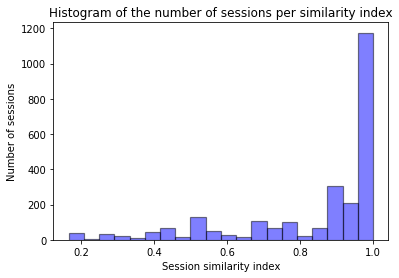

In [163]:
total_sessions = len(session_similarities)
n_unequal_sessions = sum(1 for x in session_similarities if x[1] != 1.0)

print("Total sessions:", total_sessions)
print("Number of sessions with unequal traceroute results", n_unequal_sessions)
print("Percentage of sessions with unequal traceroute results", n_unequal_sessions / total_sessions * 100, "%")
print("Average similarity index", np.mean([x[1] for x in session_similarities]))
print("Std deviation of similarity index", np.std([x[1] for x in session_similarities]))

x = [s[1] for s in session_similarities]
num_bins = 20
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1.2)
plt.ylabel("Number of sessions")
plt.xlabel("Session similarity index")
plt.title("Histogram of the number of sessions per similarity index")
plt.show()

From the data bove, we see that the majority of traceroutes within the same session does have the same E2E routing. Even though 51% of the traces are not identical in route, there's still an 85% similarity score on average for our packets. 

Further analysis will require examining session-similarity-index against particular website. A low session-similarity-index could be explained by 2 things: 

1. There are a lot of content distribution servers for a website. I'm guessing that this is probably the case for websites like amazon.com 
2. Network for the team's ISP is unstable  

Additionally, we should also investigate where along the trace does the route start to diverge to differentiate between #1 or #2

#### Latency consistency for same sessions

After looking at route consistency, it would also make sense to quickly look at latency consistency. (TODO)

## Since i'm still waiting for a piazza answer, i'll just pick the first traceroute result for each session to move forward with

### E2E Consistency within each day 

Here we compare the traceroute path between the 2 traceroute sessions for each day.

In [166]:
daily_session_similarities = []
for team in teams: 
    for seq in seqs:
        # Loop over all tr1 datasets for each website 
        websites = list(data[team][seq].keys())
        for website in websites:
            # Analyze tr1 data 
            df = data[team][seq][website]['tr1']
            days = df.groupby(['date'])
            
            # We want to separate out the 2 traceroute instances, which can be differentiated by the repeated hop_idx 
            for day, day_df in days:
                traces = []
                day_group = day_df.groupby(['time'])
                for time, day_time_df in day_group:
                    # We want to only take the first traceroute call instead of second 
                    start_index = -1
                    end_index = -2
                    for index, row in day_time_df.iterrows():
                        if (end_index == -2): #Ignore first entry
                            end_index = -1
                            start_index = index
                            continue

                        if (row['hop_idx'] == 1):
                            end_index = index
                            break
                    traces.append((time, day_time_df.iloc[start_index - start_index:end_index - start_index]))# Zeroing indexes
                
                # Analyze differences in traces[0][1] and traces[1][1]
                daily_session_similarities.append(("{} {} {} {}".format(day, website, seq, team), session_route_similarity_index(traces[0][1], traces[1][1])))
            

#### Overall statistics

Total days entries (total of all teams) 1260
Total number of differing routes 767
Percentage of days with differing routes 60.873015873015866 %
Average daily route similarity index 0.7885663048527072
Standard deviation of route similarity index 0.2526400491315811


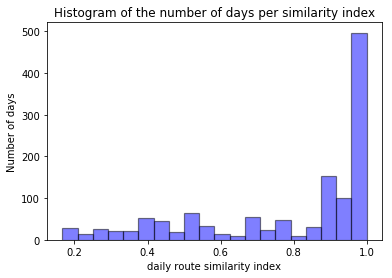

In [175]:
average_daily_session_similarities = np.mean([x[1] for x in daily_session_similarities])
std_daily_session_similarities = np.std([x[1] for x in daily_session_similarities])

total_unequal_entries = sum(1 for x in daily_session_similarities if x[1] != 1.0)
total_entries = len(daily_session_similarities)
print("Total days entries (total of all teams)", total_entries)
print("Total number of differing routes", total_unequal_entries)
print("Percentage of days with differing routes", total_unequal_entries / total_entries * 100, '%')
print("Average daily route similarity index", average_daily_session_similarities)
print("Standard deviation of route similarity index", std_daily_session_similarities)

x = [s[1] for s in daily_session_similarities]
num_bins = 20
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1.2)
plt.ylabel("Number of days")
plt.xlabel("daily route similarity index")
plt.title("Histogram of the number of days per similarity index")
plt.show()

As we can see from the above statistics, 60% of routes do have a differ within the same day. 

The average daily route similarity index is defined as the average fraction across every team of (number of identical hops)/(total number of hops). Keep in mind that an early divergence in pathing would lead to a much lower average daily route similarity index, whereas a later divergence would lead to a higher number, as the route goes through a larger proportional of identical hops. 

An average daily route similarity index of 0.79 indicates that route divergence happens later in the path. However, this number does not reflect hops to different hosts on the same network. I.e. if a website has multiple hosts across the same network, and both sessions goes to different hosts, this number would assume that the routes are completely different. For the purposes of our analysis, we want to treat hops to the same network as an identical path. 

### TODO (Yves): Do longitudinal 2 weeks data analysis  
### TODO (Yves): Do analysis on does route/latency depend on team
### TODO (Yves): Do within-day analysis on latency consistency 
### TODO (Yves): Do longitudinal 2 weeks analysis on latency consistency 
### TODO (Yves): (Extra) Create similarity index based on network instead of entire ip addr

# Network Bottleneck

In [6]:
# All data is now read, can be indexed via data[team][seq#][website][fileType]
# team: Team1...Team8
# seq#: seq1, seq2, seq3
# website: e.g. www_cnn_com
# fileType: one of ping|tr1|tr2|pchar1|pchar2|pchar_agg|api

# Seq1: tr1|tr2|ping
# Seq2: tr1|tr2|ping|api
# Seq3: ping|tr1|pchar1|pchar2|pchar_agg

- how to identify bottleneck links?
- how to measure consistency of said links?

- geographical and website destination impact?

A bottleneck link is the slowest link in terms of throughput. We call this the bottleneck link speed. However, packets from other connections may share one or more links along the path we want to measure -> lowers throughput available to us. Hence we can only consider at available bandwidth.

#### Pchar

In [372]:
data['Team2']['seq3']['www_youtube_com']['pchar2']

,website,date,time,hop_idx,hop_ip,hop_bw,hop_queing
0,www.youtube.com,05-13-2020,15:27:02,0,10.0.2.15,-1,-1.000000
1,www.youtube.com,05-13-2020,15:27:02,1,10.0.2.2,96150.234742,0.000379
2,www.youtube.com,05-13-2020,15:27:02,2,192.168.4.1,0.000000,-0.000153
3,www.youtube.com,05-13-2020,15:27:02,3,no,0.000000,-0.000226
4,www.youtube.com,05-13-2020,15:27:02,4,96.34.89.50,27545.393410,0.000528
...,...,...,...,...,...,...,...
863,www.youtube.com,05-26-2020,16:38:27,26,no,0.000000,0.000000
864,www.youtube.com,05-26-2020,16:38:27,27,no,0.000000,0.000000
865,www.youtube.com,05-26-2020,16:38:27,28,no,0.000000,0.000000
866,www.youtube.com,05-26-2020,16:38:27,29,no,0.000000,0.000000


In [376]:
test1 = data['Team2']['seq3']['www_youtube_com']['pchar1']
test2 = data['Team2']['seq3']['www_youtube_com']['pchar2']

# Drop rows without pchar response / feedback
test1 = test1[test1.hop_ip != "no"]
test2 = test2[test2.hop_ip != "no"]

# Change --.--- values to 0
test1.hop_rtt = test1.hop_rtt.replace({"--.---": "0"}, inplace=False)
test2.hop_bw = test2.hop_bw.replace({"--.---": "0"}, inplace=False)

# Change hop_rtt to int type
test1.hop_rtt = test1.hop_rtt.astype(float)
test2.hop_bw = test2.hop_bw.astype(float)
test2.hop_queing = test2.hop_queing.astype(float)

In [377]:
rtt = test1.groupby(['hop_idx'])['hop_rtt'].describe()
bw = test2.groupby(['hop_idx'])['hop_bw'].describe()

rtt

,count,mean,std,min,25%,50%,75%,max
hop_idx,,,,,,,,
0,28.0,-1.000000,0.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000
1,28.0,0.098645,0.131294,0.0,0.000000,0.000000,0.227249,0.336188
2,28.0,1.944866,1.901192,0.0,0.000000,2.194816,2.866289,6.294726
4,28.0,12.132511,10.595655,0.0,10.995725,12.529800,13.797600,57.151200
5,28.0,0.222757,0.624680,0.0,0.000000,0.000000,0.000000,2.473300
6,28.0,0.679482,1.258300,0.0,0.000000,0.000000,0.814775,4.327400
7,28.0,0.726057,1.526547,0.0,0.000000,0.000000,0.080125,6.128500
8,28.0,15.046793,11.057987,0.0,0.000000,18.945100,25.039750,26.960800
9,28.0,0.225036,0.785872,0.0,0.000000,0.000000,0.000000,3.730200


Concat two dataframes to get [bw, rtt] and run some analysis on them:

In [380]:
# TODO

#### Traceroute

Let's try to understand the latency distribution for all `hop_idx` or `hop_ip` of a (team, website)

In [15]:
test = data['Team2']['seq1']['www_cnn_com']['tr1']
test

,website,date,time,hop_idx,hop_ip,latency1,latency2,latency3,latency_avg
0,www.cnn.com,05-13-2020,15:18:07,1,(10.0.2.2),0.188,0.151,0.139,0.159333
1,www.cnn.com,05-13-2020,15:18:07,2,(192.168.4.1),3.472,3.487,3.445,3.468000
2,www.cnn.com,05-13-2020,15:18:07,3,-1,-1.000,-1.000,-1.000,-1.000000
3,www.cnn.com,05-13-2020,15:18:07,4,(96.34.89.50),13.462,13.458,13.451,13.457000
4,www.cnn.com,05-13-2020,15:18:07,5,(96.34.89.9),13.385,13.391,13.403,13.393000
...,...,...,...,...,...,...,...,...,...
1003,www.cnn.com,05-26-2020,16:29:34,10,(96.34.0.14),61.334,61.341,61.329,61.334667
1004,www.cnn.com,05-26-2020,16:29:34,11,(96.34.0.12),66.119,66.115,68.029,66.754333
1005,www.cnn.com,05-26-2020,16:29:34,12,(96.34.3.11),64.859,66.194,65.072,65.375000
1006,www.cnn.com,05-26-2020,16:29:34,13,(157.52.127.250),54.701,54.641,54.606,54.649333


Here is a description of the measurements per hop per run:

In [114]:
test.groupby(['hop_idx', 'date', 'time'])['latency_avg'].describe()

count       mean       std        min        25%  \
hop_idx date       time                                                         
1       05-13-2020 15:18:07    2.0   0.176500  0.024277   0.159333   0.167917   
                   16:45:04    2.0   0.210000  0.000471   0.209667   0.209833   
        05-14-2020 15:16:02    2.0   0.650333  0.701450   0.154333   0.402333   
                   16:42:02    2.0   0.243000  0.035827   0.217667   0.230333   
        05-15-2020 16:43:58    2.0   0.305000  0.227217   0.144333   0.224667   
...                            ...        ...       ...        ...        ...   
21      05-18-2020 16:43:23    2.0  61.028500  2.899845  58.978000  60.003250   
        05-19-2020 15:14:48    2.0  59.063667  0.551543  58.673667  58.868667   
                   16:41:27    2.0  59.502333  0.441235  59.190333  59.346333   
        05-20-2020 15:11:37    2.0  59.688500  2.085258  58.214000  58.951250   
                   16:43:32    2.0  63.070167  5.187100  59.402333  61.236250   

                                   50%        75%        max  
hop_idx date       time                                       
1       05-13-2020 15:18:07   0.176500   0.185083   0.193667  
                   16:45:04   0.210000   0.210167   0.210333  
        05-14-2020 15:16:02   0.650333   0.898333   1.146333  
                   16:42:02   0.243000   0.255667   0.268333  
        05-15-2020 16:43:58   0.305000   0.385333   0.465667  
...                                ...        ...        ...  
21      05-18-2020 16:43:23  61.028500  62.053750  63.079000  
        05-19-2020 15:14:48  59.063667  59.258667  59.453667  
                   16:41:27  59.502333  59.658333  59.814333  
        05-20-2020 15:11:37  59.688500  60.425750  61.163000  
                   16:43:32  63.070167  64.904083  66.738000  

[504 rows x 8 columns]

Here is a description of the measurements per hop per day (not per run). There are two runs, so four traceroutes in a day:

In [112]:
test.groupby(['hop_idx', 'date'])['latency_avg'].describe()

count       mean       std        min        25%  \
hop_idx date                                                           
1       05-13-2020    4.0   0.193250  0.023888   0.159333   0.185083   
        05-14-2020    4.0   0.446667  0.468770   0.154333   0.201833   
        05-15-2020    4.0   0.268667  0.138931   0.144333   0.193583   
        05-16-2020    4.0   0.515500  0.677990   0.160000   0.178500   
        05-17-2020    4.0   0.424750  0.439164   0.114333   0.189583   
...                   ...        ...       ...        ...        ...   
21      05-16-2020    4.0  54.436583  1.079758  53.062667  54.049417   
        05-17-2020    4.0  54.183583  0.997728  52.944000  53.648750   
        05-18-2020    4.0  60.418917  1.838351  58.978000  59.340000   
        05-19-2020    4.0  59.283000  0.480040  58.673667  59.061167   
        05-20-2020    4.0  61.379333  3.772266  58.214000  59.105250   

                          50%        75%        max  
hop_idx date                                         
1       05-13-2020   0.201667   0.209833   0.210333  
        05-14-2020   0.243000   0.487833   1.146333  
        05-15-2020   0.232333   0.307417   0.465667  
        05-16-2020   0.184833   0.521833   1.532333  
        05-17-2020   0.255333   0.490500   1.074000  
...                       ...        ...        ...  
21      05-16-2020  54.496000  54.883167  55.691667  
        05-17-2020  54.270667  54.805500  55.249000  
        05-18-2020  59.809333  60.888250  63.079000  
        05-19-2020  59.322000  59.543833  59.814333  
        05-20-2020  60.282667  62.556750  66.738000  

[252 rows x 8 columns]

Group by run and get a five statistics summary, which we use for a quick scatter plot:

In [172]:
y = test.groupby(['hop_idx', 'date', 'time'])['latency_avg'].describe().reset_index()
y

,hop_idx,date,time,count,mean,std,min,25%,50%,75%,max
0,1,05-13-2020,15:18:07,2.0,0.176500,0.024277,0.159333,0.167917,0.176500,0.185083,0.193667
1,1,05-13-2020,16:45:04,2.0,0.210000,0.000471,0.209667,0.209833,0.210000,0.210167,0.210333
2,1,05-14-2020,15:16:02,2.0,0.650333,0.701450,0.154333,0.402333,0.650333,0.898333,1.146333
3,1,05-14-2020,16:42:02,2.0,0.243000,0.035827,0.217667,0.230333,0.243000,0.255667,0.268333
4,1,05-15-2020,16:43:58,2.0,0.305000,0.227217,0.144333,0.224667,0.305000,0.385333,0.465667
...,...,...,...,...,...,...,...,...,...,...,...
499,21,05-18-2020,16:43:23,2.0,61.028500,2.899845,58.978000,60.003250,61.028500,62.053750,63.079000
500,21,05-19-2020,15:14:48,2.0,59.063667,0.551543,58.673667,58.868667,59.063667,59.258667,59.453667
501,21,05-19-2020,16:41:27,2.0,59.502333,0.441235,59.190333,59.346333,59.502333,59.658333,59.814333
502,21,05-20-2020,15:11:37,2.0,59.688500,2.085258,58.214000,58.951250,59.688500,60.425750,61.163000


In [190]:
# Get hop count per date
# test.groupby(['hop_idx', 'date'])['latency_avg'].count().reset_index().groupby('date')['hop_idx'].count()

labels = y['hop_idx'].unique()
# y['normalized_std'] = y['std']/y['mean']

In [181]:
# y.loc[y['hop_idx']==hop]

##### Latency distribution 

Now we can assess the distribution of latencies across hops

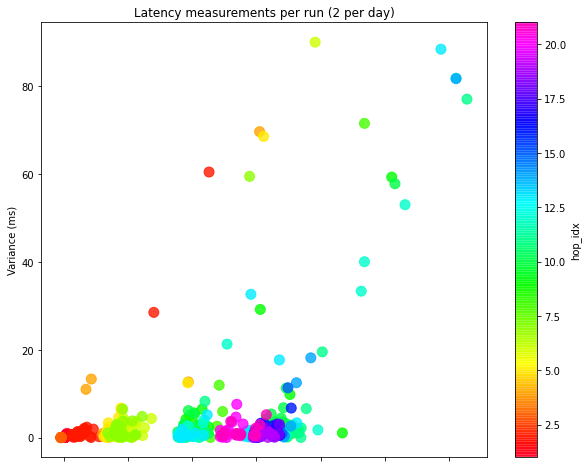

In [247]:
scatterplot = y.plot.scatter(x='mean', y='std', c='hop_idx', s=100, alpha=0.8, figsize=(10,8),
                            colormap='gist_rainbow', colorbar=True)
plt.title('Latency measurements per run (2 per day)')
plt.xlabel('Mean latency (ms)')
plt.ylabel('Variance (ms)')
plt.show()

For some reason the x-axis label does not show up, but it is the mean latency of that run.

As you can see, there are a couple of outliers with both high latency and high variance around hop 11 - 14. Let us take a closer look by plotting the distribution per hop.

In [146]:
# Plot latency distribution for each hop but with title
# for hop in y['hop_idx'].unique():
#     plt.figure()
#     plt.title('Avg latency across days for hop' + str(hop))
#     tmp = y.loc[y['hop_idx']==hop]
#     plt.hist(tmp['mean'],alpha=0.9)
#     plt.xlabel('Latency (ms)')
#     plt.ylabel('Frequency')
#     plt.show()

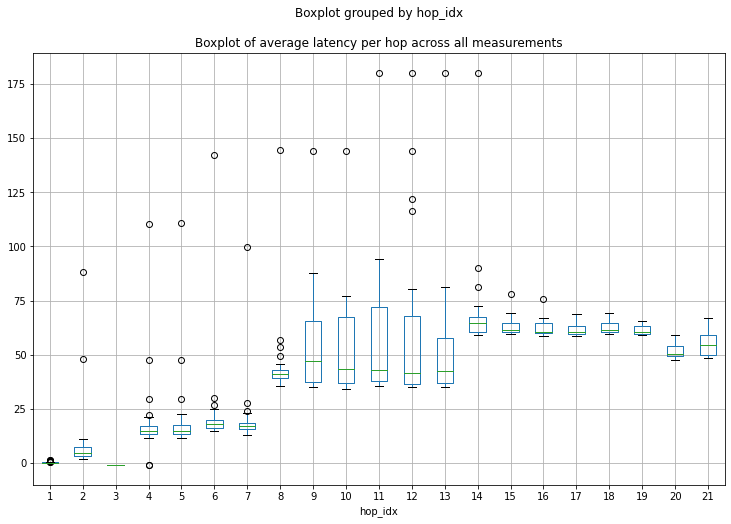

In [188]:
# Plot 3 subplots for each latency1/2/3 measurement (unnecessary)
# boxplot = test.boxplot(column=['latency1', 'latency2', 'latency3'], by='hop_idx', figsize=(20,20))

# Plot latency average
boxplot = test.boxplot(column=['latency_avg'], by='hop_idx', figsize=(12, 8))
plt.title('Boxplot of average latency per hop across all measurements')
plt.show()

As you can see, significant variance in latency appears in hop 9 and continues until hop 13. 

We can get a high level overview by plotting the **intra-hop** distribution (not sharing x-axis)

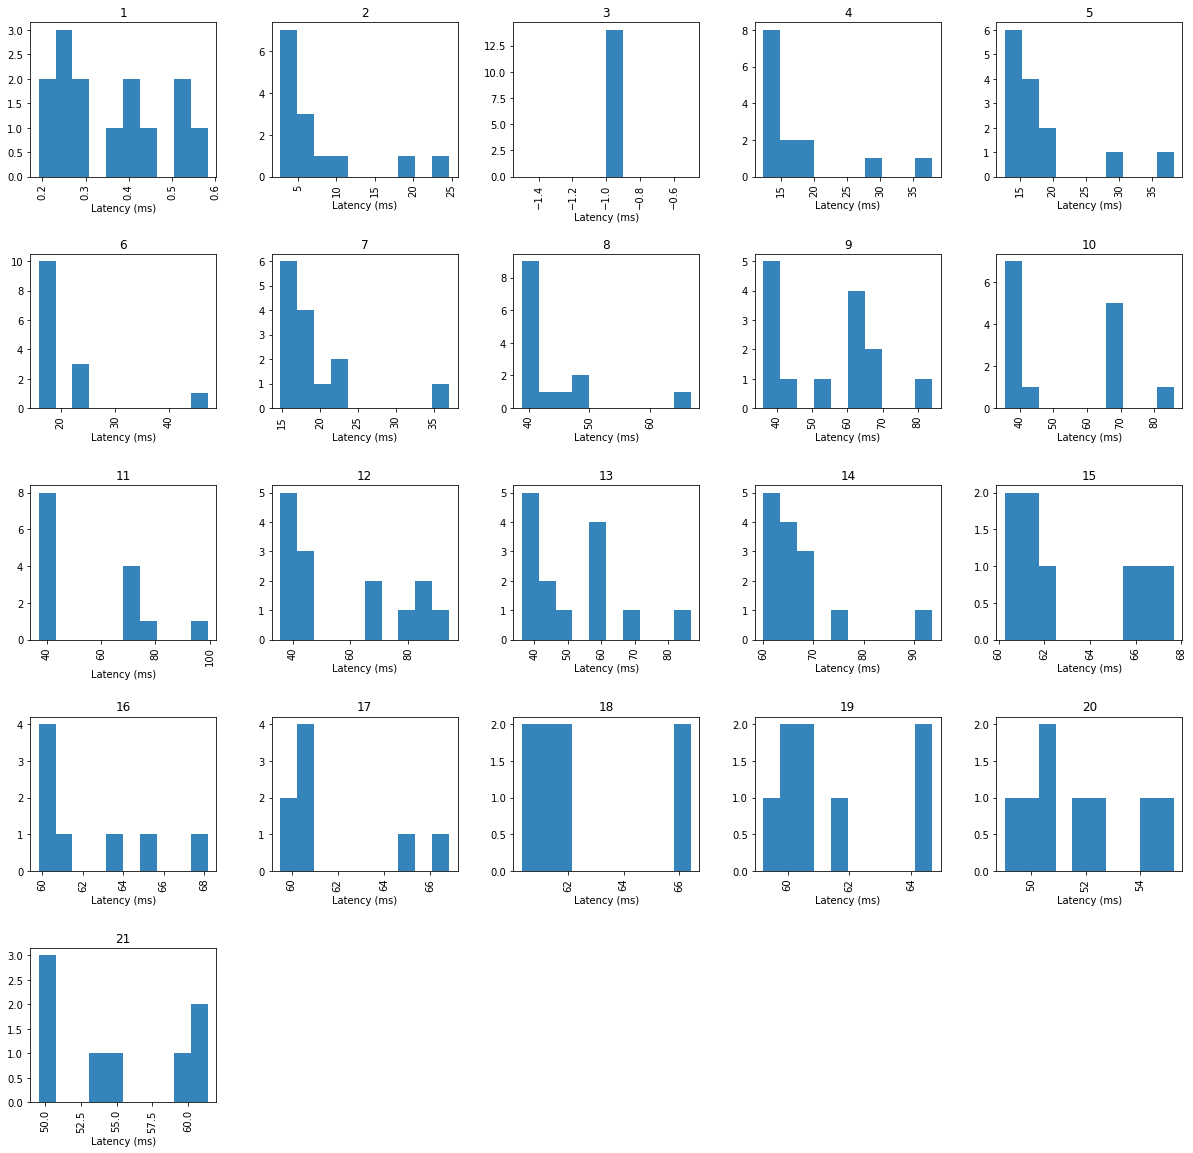

In [174]:
# Plot the distribution of latency for each hop on same latency scale given a website traceroute
axarr = x.hist(by='hop_idx', figsize=(20,20),alpha=0.9)
for idx, ax in enumerate(axarr.flatten()):
    ax.set_xlabel("Latency (ms)")

Here we show the plots on identical latency axis to get a better sense of the **inter-hop** latency distribution

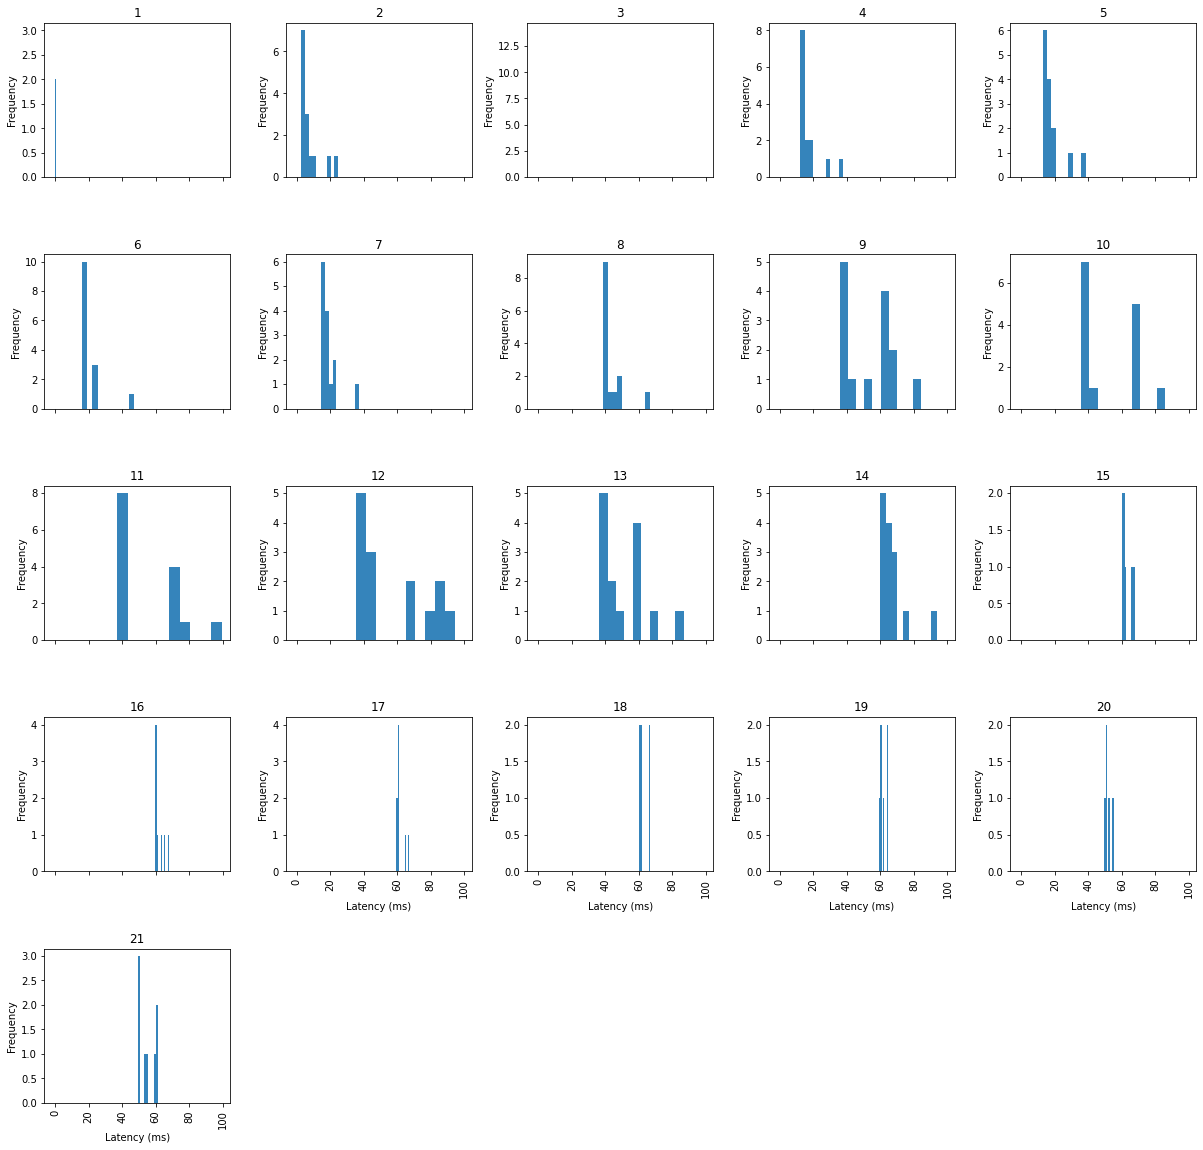

In [147]:
# Plot the distribution of latency for each hop on same latency scale
axarr = x.hist(by='hop_idx', figsize=(20,20),alpha=0.9, sharex=True)
for idx, ax in enumerate(axarr.flatten()):
    ax.set_xlabel("Latency (ms)")
    ax.set_ylabel("Frequency")

We now want to assess whether the bottleneck link is consistent across time.

In [288]:
# Pick bottleneck links
hops = [9, 10, 11, 12, 13]

# Group per day
by_day = test.groupby(['hop_idx', 'date'])['latency_avg'].describe().reset_index()

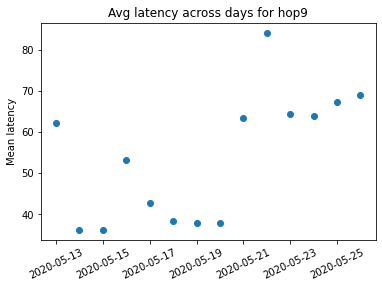

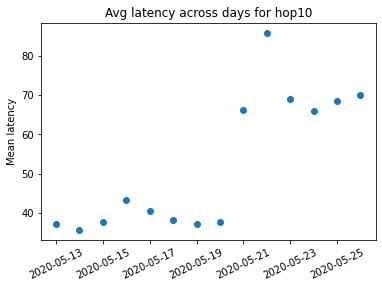

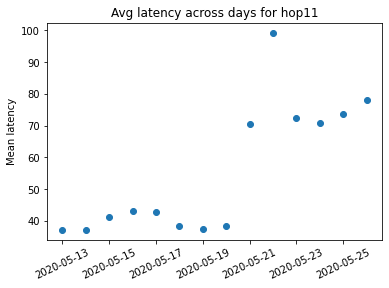

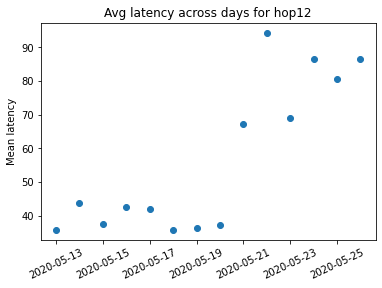

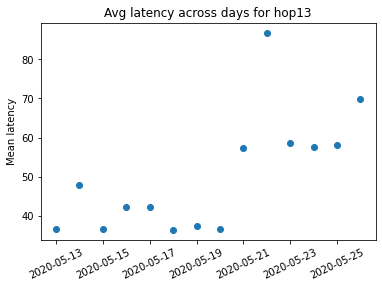

In [298]:
from matplotlib.dates import datestr2num

for h in hops:
    plt.figure()
    plt.title('Avg latency across days for hop' + str(h))
    converted_dates = datestr2num(by_day.loc[by_day['hop_idx']==h]['date'])
    fig = plt.plot_date(converted_dates, by_day.loc[by_day['hop_idx']==h]['mean'])
    plt.xticks(rotation=25)
    plt.ylabel('Mean latency')
    plt.show()

From the above, we can observe a few things:
    1. One is that the mean latency jumps on May 21 and persists for the remainder of the tests for all hops
    2. Two is that we now have more insight into the latency differences between hops 9 through 13. 
    
From two, I would argue that hop 9 can now be qualified as the bottleneck link since it has much higher mean latencies on days that the other hops do not face increased latencies